In [1]:
# import osmnx as ox
import pandas as pd
import geopandas as gpd
import json
from io import StringIO
import warnings
import sys
import os
warnings.filterwarnings("ignore")
sys.stderr = open(os.devnull, 'w')


## Версия 1 

In [35]:
region = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/region.geojson')
region

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,-77665.0,Волгоградская область,Волгоградская область,2507509.0,2491036.0,2474556.0,2449781.0,2470057.0,4,18000000000,,область,"MULTIPOLYGON (((41.16810 50.77451, 41.17850 50..."


In [36]:
district = gpd.read_file('C:\Code\PopFrame\examples\data/territories\shlis.geojson')

In [37]:
settlement = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/settlement.geojson')
settlement

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,NaN,Революционное,Палласовский район,1238.0,1218.0,1215.0,1206.0,1056.0,8,None,None,сельское поселение,"MULTIPOLYGON (((46.78903 49.63836, 46.73639 49..."
1,-1446299.0,Стеженское,Алексеевский район,685.0,675.0,694.0,675.0,630.0,8,None,None,сельское поселение,"MULTIPOLYGON (((41.97687 50.29195, 41.97739 50..."
2,-1443108.0,Краснооктябрьское,Алексеевский район,769.0,748.0,725.0,668.0,929.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.36857 50.28091, 42.36860 50..."
3,-1443107.0,Ларинское,Алексеевский район,714.0,713.0,700.0,694.0,663.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.21293 50.28499, 42.21300 50..."
4,-1443106.0,Яминское,Алексеевский район,1417.0,1399.0,1384.0,1376.0,1393.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.19721 50.32547, 42.20512 50..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1676128.0,Красноярское,Чернышковский район,1124.0,1110.0,1105.0,1105.0,984.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.27296 48.40632, 42.27870 48..."
430,-1676127.0,Большетерновское,Чернышковский район,795.0,777.0,745.0,722.0,750.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.29665 48.45521, 42.32227 48..."
431,-1676000.0,Пристеновское,Чернышковский район,467.0,455.0,442.0,435.0,497.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.72587 48.28015, 42.72692 48..."
432,-1675999.0,Алешкинское,Чернышковский район,380.0,375.0,364.0,349.0,370.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.48190 48.22617, 42.49394 48..."


In [38]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from retrying import retry
from matplotlib.lines import Line2D
import contextily as ctx

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    # Определение тегов для каждого показателя
    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }
    
    # Собираем все уникальные теги
    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('boundary_') and not tag.startswith('place_')] + \
                  [{'boundary': 'administrative'}] + \
                  [{'place': 'city'}]
    
    # Параллельная загрузка данных по уникальным тегам
    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    # Распределение данных по категориям
    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
        for tag in tags:
            if tag.startswith('boundary_'):
                tag_filter = {'boundary': 'administrative'}
            elif tag.startswith('place_'):
                tag_filter = {'place': 'city'}
            else:
                tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_gdf = category_gdf.append(gdf, ignore_index=True)
        landuse_gdfs[category] = category_gdf
        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf = region_gdf.dropna(subset=['geometry'])  # Удаление строк с NaN в геометрии
    region_gdf = region_gdf[~region_gdf.is_empty]  # Удаление пустых геометрий
    
    if region_gdf.empty:
        raise ValueError("Region GeoDataFrame is empty after cleaning.")

    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6  # Площадь региона в квадратных километрах
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf = gdf.dropna(subset=['geometry'])  # Удаление строк с NaN в геометрии
            gdf = gdf[~gdf.is_empty]  # Удаление пустых геометрий
            
            # Удаление строк с NaN в координатах геометрий
            gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom is not None and not geom.is_empty else None)
            gdf = gdf.dropna(subset=['geometry'])
            
            if gdf.empty:
                continue

            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            
            # Разделение на типы геометрий
            for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                if not gdf_geom_type.empty:
                    # Пересечение с регионом
                    gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                    landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6  # Площадь в квадратных километрах
                    total_landuse_areas_km2[key] += landuse_area_km2

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    
    return urbanization_data



def plot_landuse(region_gdf, landuse_gdfs):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM

    fig, ax = plt.subplots(figsize=(10, 10))  # Увеличим размер фигуры
    ax.set_axis_off()  # Отключение осей
    
    region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Граница региона')

    colors = {
        'Застройка жилищным строительством': 'blue',
        'Сельскохозяйственные земли': 'yellow',
        'Промышленные земли': 'gray',
        'Лесные массивы': 'green',
        'Земли специального назначения': 'brown',
        'Земли населенных пунктов': 'orange',
        'Особо охраняемые природные территории': 'purple',
        'Водный фонд': 'cyan'
    }
    
    landuse_mapping = {
        '1.3.1 Процент застройки жилищным строительством': 'Застройка жилищным строительством',
        '1.3.2 Процент земель сельскохозяйственного назначения': 'Сельскохозяйственные земли',
        '1.3.3 Процент земель промышленного назначения': 'Промышленные земли',
        '1.3.4 Процент земель, занимаемыми лесными массивами': 'Лесные массивы',
        '1.3.5 Процент земель специального назначения': 'Земли специального назначения',
        '1.3.6 Процент земель населенных пунктов': 'Земли населенных пунктов',
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 'Особо охраняемые природные территории',
        '1.3.8 Процент земель, занимаемых водным фондом': 'Водный фонд'
    }
    
    for key, gdf in landuse_gdfs.items():
        if not gdf.empty:
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            label = landuse_mapping.get(key, key)
            gdf_utm.plot(ax=ax, color=colors.get(label, 'gray'), alpha=0.5, label=label)
    
    # Добавление подложки карты
    ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Создание пользовательских меток для легенды
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10) 
                       for label, color in colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))  # Перемещение легенды в верхнюю часть справа
    plt.show()


In [39]:
district = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
gdf_region = district.loc[[32]].reset_index(drop=True)

# gdf_region = district.iloc[:1]
# gdf_region = district
gdf_region_utm = gdf_region

# Проверка CRS
print(gdf_region_utm.crs)

# Вычисление площади в квадратных метрах и преобразование в квадратные километры
gdf_region_utm['area_km2'] = gdf_region_utm.geometry.area / 1e6  # 1 км² = 1,000,000 м²

# Суммарная площадь региона в квадратных километрах
region_area_km2 = gdf_region_utm['area_km2'].sum()
print(f"Region area in square kilometers: {region_area_km2}")

EPSG:4326
Region area in square kilometers: 1.0741837093770464e-07


In [40]:
landuse_gdfs_list = []

for idx, district in gdf_region_utm.iterrows():
    polygon = district.geometry
    landuse_gdfs = get_landuse_data(polygon)
    landuse_gdfs_list.append(landuse_gdfs)

# Расчет степени урбанизации для всего региона
urbanization_data = calculate_urbanization(gdf_region, landuse_gdfs_list)

total_percentage = sum(urbanization_data.values())
print(f"Total percentage: {total_percentage}")


Polygon bounds: (44.1087686, 48.4070531, 44.6874279, 48.8890717)


KeyboardInterrupt: 

In [ ]:
urbanization_data

{'1.3.1 Процент застройки жилищным строительством': 10.1,
 '1.3.2 Процент земель сельскохозяйственного назначения': 17.2,
 '1.3.3 Процент земель промышленного назначения': 5.4,
 '1.3.4 Процент земель, занимаемыми лесными массивами': 0.2,
 '1.3.5 Процент земель специального назначения': 1.3,
 '1.3.6 Процент земель населенных пунктов': 98.3,
 '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 0.0,
 '1.3.8 Процент земель, занимаемых водным фондом': 0.0}

In [ ]:
plot_landuse(gdf_region, landuse_gdfs)

NameError: name 'plot_landuse' is not defined

In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from retrying import retry
from matplotlib.lines import Line2D
import contextily as ctx
import pandas as pd

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    # Определение тегов для каждого показателя
    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }
    
    # Собираем все уникальные теги
    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('boundary_') and not tag.startswith('place_')] + \
                  [{'boundary': 'administrative'}] + \
                  [{'place': 'city'}]
    
    # Параллельная загрузка данных по уникальным тегам
    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    # Распределение данных по категориям
    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
        for tag in tags:
            if tag.startswith('boundary_'):
                tag_filter = {'boundary': 'administrative'}
            elif tag.startswith('place_'):
                tag_filter = {'place': 'city'}
            else:
                tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_gdf = category_gdf.append(gdf, ignore_index=True)
        landuse_gdfs[category] = category_gdf
        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf = region_gdf.dropna(subset=['geometry'])
    region_gdf = region_gdf[~region_gdf.is_empty]
    
    if region_gdf.empty:
        raise ValueError("Region GeoDataFrame is empty after cleaning.")

    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf = gdf.dropna(subset=['geometry'])
            gdf = gdf[~gdf.is_empty]
            
            gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom is not None and not geom.is_empty else None)
            gdf = gdf.dropna(subset=['geometry'])
            
            if gdf.empty:
                continue

            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)
            
            for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                if not gdf_geom_type.empty:
                    gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                    landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6
                    total_landuse_areas_km2[key] += landuse_area_km2

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    
    return urbanization_data

def process_districts(districts_gdf):
    results = []
    for idx, district in districts_gdf.iterrows():
        district_gdf = gpd.GeoDataFrame([district], columns=districts_gdf.columns)
        landuse_data = get_landuse_data(district_gdf.geometry.iloc[0])
        urbanization_data = calculate_urbanization(district_gdf, [landuse_data])
        
        total_percentage = sum(urbanization_data.values())
        urbanization_data['1.3 Степень урбанизации территории'] = total_percentage
        
        for key, value in urbanization_data.items():
            results.append({
                '№ п/п': key.split(' ')[0],
                'Название хранимое': ' '.join(key.split(' ')[1:]) if ' ' in key else key,  # Удаление первой части и оставление только текста
                'ед.изм.': '%',
                'Значение': value,
                'Территория': district['name'],  # Assuming there's a 'name' column for district names
                'Источник': 'modeled',
                'Период': 2024
            })
    
    results_gdf = pd.DataFrame(results)
    return gpd.GeoDataFrame(results_gdf)

# Пример использования:
# districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
# # districts_gdf = districts_gdf.iloc[:2]
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
districts_gdf = district.loc[[32]].reset_index(drop=True)
result_gdf = process_districts(districts_gdf)
result_gdf

Polygon bounds: (44.1087686, 48.4070531, 44.6874279, 48.8890717)
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'protected_area'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'detached'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'railway'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'salt_pond'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Err

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,10.1,Волгоград,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,17.2,Волгоград,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,5.4,Волгоград,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,0.2,Волгоград,modeled,2024
4,1.3.5,Процент земель специального назначения,%,1.3,Волгоград,modeled,2024
5,1.3.6,Процент земель населенных пунктов,%,98.3,Волгоград,modeled,2024
6,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,Волгоград,modeled,2024
7,1.3.8,"Процент земель, занимаемых водным фондом",%,0.0,Волгоград,modeled,2024
8,1.3,Степень урбанизации территории,%,132.5,Волгоград,modeled,2024


## Версия 2

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

def plot_landuse(region_gdf, landuse_gdfs):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM

    fig, ax = plt.subplots(figsize=(10, 10))  # Увеличим размер фигуры
    ax.set_axis_off()  # Отключение осей
    
    region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Граница региона')

    colors = {
        'Застройка жилищным строительством': 'blue',
        'Сельскохозяйственные земли': 'yellow',
        'Промышленные земли': 'gray',
        'Лесные массивы': 'green',
        'Земли специального назначения': 'brown',
        'Земли населенных пунктов': 'orange',
        'Особо охраняемые природные территории': 'purple',
        'Водный фонд': 'cyan'
    }
    
    landuse_mapping = {
        '1.3.1 Процент застройки жилищным строительством': 'Застройка жилищным строительством',
        '1.3.2 Процент земель сельскохозяйственного назначения': 'Сельскохозяйственные земли',
        '1.3.3 Процент земель промышленного назначения': 'Промышленные земли',
        '1.3.4 Процент земель, занимаемыми лесными массивами': 'Лесные массивы',
        '1.3.5 Процент земель специального назначения': 'Земли специального назначения',
        '1.3.6 Процент земель населенных пунктов': 'Земли населенных пунктов',
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 'Особо охраняемые природные территории',
        '1.3.8 Процент земель, занимаемых водным фондом': 'Водный фонд'
    }
    
    for key, gdf in landuse_gdfs.items():
        if not gdf.empty:
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            label = landuse_mapping.get(key, key)
            gdf_utm.plot(ax=ax, color=colors.get(label, 'gray'), alpha=0.5, label=label)
    
    # Добавление подложки карты
    ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Создание пользовательских меток для легенды
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10) 
                       for label, color in colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))  # Перемещение легенды в верхнюю часть справа
    plt.show()

In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, GeometryCollection
from shapely.ops import unary_union
from concurrent.futures import ThreadPoolExecutor, as_completed
from retrying import retry
import pandas as pd

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest', 'wood'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city', 'place_town'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }

    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('place_')] + \
                  [{'place': 'city'}, {'place': 'town'}] + \
                  [{'natural': 'water'}, {'natural': 'wood'}]

    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_geoms = []
        for tag in tags:
            if tag.startswith('place_'):
                tag_filter = {'place': 'city' if tag == 'place_city' else 'town'}
            else:
                tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_geoms.extend(gdf.geometry)
        
        if category_geoms:
            valid_geoms = [geom for geom in category_geoms if geom.is_valid]
            valid_geoms = [geom.buffer(0) for geom in valid_geoms]  # Исправление геометрии буфером с нулевым значением
            category_union = unary_union(valid_geoms)
            category_intersect = category_union.intersection(polygon)
            if isinstance(category_intersect, (Polygon, MultiPolygon)):
                category_gdf = gpd.GeoDataFrame(geometry=[category_intersect], crs='EPSG:4326')
            elif isinstance(category_intersect, GeometryCollection):
                category_gdf = gpd.GeoDataFrame(geometry=[geom for geom in category_intersect.geoms if isinstance(geom, (Polygon, MultiPolygon))], crs='EPSG:4326')
            else:
                category_gdf = gpd.GeoDataFrame(geometry=[], crs='EPSG:4326')
            landuse_gdfs[category] = category_gdf
        else:
            landuse_gdfs[category] = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')

        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf = region_gdf.dropna(subset=['geometry'])
    region_gdf = region_gdf[~region_gdf.is_empty]
    
    if region_gdf.empty:
        raise ValueError("Region GeoDataFrame is empty after cleaning.")

    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}
    all_landuse_geoms = []
    
    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf = gdf.dropna(subset=['geometry'])
            gdf = gdf[~gdf.is_empty]
            
            gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom is not None and not geom.is_empty else None)
            gdf = gdf.dropna(subset=['geometry'])
            
            if gdf.empty:
                continue

            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)
            
            all_landuse_geoms.extend(gdf_utm.geometry)
            
            if key != '1.3 Степень урбанизации территории':
                for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                    gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                    if not gdf_geom_type.empty:
                        gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                        landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6
                        total_landuse_areas_km2[key] += landuse_area_km2
    
    valid_geoms = [geom for geom in all_landuse_geoms if geom.is_valid]
    valid_geoms = [geom.buffer(0) for geom in valid_geoms]  # Исправление геометрии буфером с нулевым значением
    all_landuse_union = unary_union(valid_geoms)
    if isinstance(all_landuse_union, GeometryCollection):
        all_landuse_union = [geom for geom in all_landuse_union.geoms if isinstance(geom, (Polygon, MultiPolygon))]
    else:
        all_landuse_union = [all_landuse_union]

    all_landuse_union_gdf = gpd.GeoDataFrame(geometry=all_landuse_union, crs=region_gdf_utm.crs)
    all_landuse_union_intersect = gpd.overlay(all_landuse_union_gdf, region_gdf_utm, how='intersection')
    total_urbanization_area_km2 = all_landuse_union_intersect.geometry.area.sum() / 1e6

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    urbanization_data['1.3 Степень урбанизации территории'] = round((total_urbanization_area_km2 / region_area_km2) * 100, 1)
    
    return urbanization_data

def process_districts(districts_gdf):
    results = []
    for idx, district in districts_gdf.iterrows():
        district_gdf = gpd.GeoDataFrame([district], columns=districts_gdf.columns)
        landuse_data = get_landuse_data(district_gdf.geometry.iloc[0])
        urbanization_data = calculate_urbanization(district_gdf, [landuse_data])
        
        for key, value in urbanization_data.items():
            results.append({'№ п/п': key.split(' ')[0],
                'Название хранимое': ' '.join(key.split(' ')[1:]) if ' ' in key else key,
                'ед.изм.': '%',
                'Значение': value,
                'Территория': district['name'],  # Предполагается, что есть колонка 'name' для названий районов
                'Источник': 'modeled',
                'Период': 2024
            })
    
    results_gdf = pd.DataFrame(results)
    return gpd.GeoDataFrame(results_gdf)

In [ ]:
districts_gdf = gpd.read_file('C:\Code\PopFrame\data_9\moskva\districts.geojson')
districts_gdf

,osm_id,boundary,admin_level,parents,name,layer,2019,2020,2021,2022,2023,key,admin_center,status,geometry
0,-1320234,administrative,5,"-102269,-1029256,-60189",Восточный,Восточный административный округ,1523420.0,1527316.0,1524265.0,1514420.0,1509702.0,45263000000,None,административный округ,"MULTIPOLYGON (((37.65012 55.79279, 37.65045 55..."
1,-226149,administrative,5,"-102269,-1029256,-60189",Западный,Западный административный округ,1392993.0,1397114.0,1395986.0,1383853.0,1436899.0,45268000000,None,административный округ,"MULTIPOLYGON (((36.88808 55.73444, 36.88914 55..."
2,-1320358,administrative,5,"-102269,-1029256,-60189",Зеленоградский,Зеленоградский административный округ,246535.0,250453.0,250173.0,253687.0,262505.0,45272000000,None,административный округ,"MULTIPOLYGON (((37.13160 56.01645, 37.13395 56..."
3,-2263058,administrative,5,"-102269,-1029256,-60189",Новомосковский,Новомосковский административный округ,259682.0,274170.0,275508.0,300375.0,528621.0,45297000000,None,административный округ,"MULTIPOLYGON (((37.08720 55.59048, 37.08735 55..."
4,-162903,administrative,5,"-102269,-1029256,-60189",Северный,Северный административный округ,1185416.0,1188312.0,1186128.0,1175229.0,1208839.0,45277000000,None,административный округ,"MULTIPOLYGON (((37.33132 55.93387, 37.33345 55..."
5,-1252558,administrative,5,"-102269,-1029256,-60189",Северо-Восточный,Северо-Восточный административный округ,1431976.0,1434842.0,1432571.0,1427597.0,1438138.0,45283000000,None,административный округ,"MULTIPOLYGON (((37.51923 55.94194, 37.51998 55..."
6,-446092,administrative,5,"-102269,-1029256,-60189",Северо-западный,Северо-Западный административный округ,1008968.0,1012949.0,951998.0,1009217.0,1032775.0,45293000000,None,административный округ,"MULTIPOLYGON (((37.33204 55.84595, 37.33206 55..."
7,-2263059,administrative,5,"-102269,-1029256,-60189",Троицкий,Троицкий административный округ,127349.0,130812.0,130315.0,142767.0,191880.0,45298000000,None,административный округ,"MULTIPOLYGON (((36.80310 55.44083, 36.81136 55..."
8,-2162196,administrative,5,"-102269,-1029256,-60189",Центральный,Центральный административный округ,782048.0,783886.0,779352.0,779086.0,771733.0,45286000000,None,административный округ,"MULTIPOLYGON (((37.51393 55.75842, 37.51454 55..."
9,-1278703,administrative,5,"-102269,-1029256,-60189",Юго-восточный,Юго-Восточный административный округ,1418430.0,1433828.0,1431746.0,1432839.0,1505836.0,45290000000,None,административный округ,"MULTIPOLYGON (((37.66069 55.73070, 37.66076 55..."


In [ ]:
# districts_gdf = gpd.read_file('C:\Code\PopFrame\examples\data\territories\lodey.geojson')
# districts_gdf = districts_gdf.loc[[34]].reset_index(drop=True)
result_gdf = process_districts(districts_gdf)
result_gdf

Polygon bounds: (28.8815453511956, 61.10601714720027, 29.02149011572418, 61.1540659128099)
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'residential'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'plant_nursery'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'orchard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'brownfield'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'industrial'}: No data elements in server response. Check l

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,0.0,None,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,8.4,None,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,0.2,None,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,86.5,None,modeled,2024
4,1.3.5,Процент земель специального назначения,%,0.0,None,modeled,2024
5,1.3.6,Процент земель населенных пунктов,%,0.0,None,modeled,2024
6,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,None,modeled,2024
7,1.3.8,"Процент земель, занимаемых водным фондом",%,0.5,None,modeled,2024
8,1.3,Степень урбанизации территории,%,94.9,None,modeled,2024


In [ ]:
result_gdf["Территория"] = result_gdf["Территория"].fillna("Светогорское городское поселение")
result_gdf

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,0.0,Светогорское городское поселение,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,8.4,Светогорское городское поселение,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,0.2,Светогорское городское поселение,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,86.5,Светогорское городское поселение,modeled,2024
4,1.3.5,Процент земель специального назначения,%,0.0,Светогорское городское поселение,modeled,2024
5,1.3.6,Процент земель населенных пунктов,%,0.0,Светогорское городское поселение,modeled,2024
6,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,Светогорское городское поселение,modeled,2024
7,1.3.8,"Процент земель, занимаемых водным фондом",%,0.5,Светогорское городское поселение,modeled,2024
8,1.3,Степень урбанизации территории,%,94.9,Светогорское городское поселение,modeled,2024


Polygon bounds: (37.6501162, 55.6952975, 37.9456503, 56.0097028)
Error fetching data for tag filter {'landuse': 'quarry'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'aquaculture'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'nature_reserve'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'conservation'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'apartments'}: No data elements in server response. Check log and query location

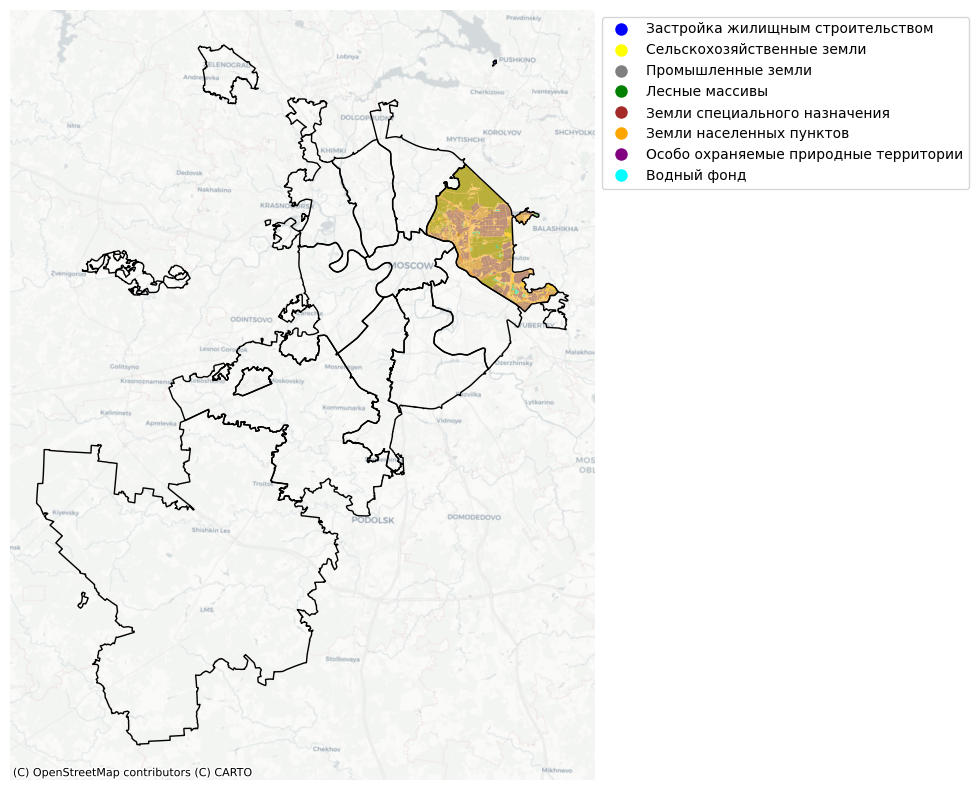

In [ ]:
landuse_data = get_landuse_data(districts_gdf.geometry.iloc[0])
urbanization_data = calculate_urbanization(districts_gdf, [landuse_data])
plot_landuse(districts_gdf, landuse_data)

In [ ]:
landuse_data

{'1.3.1 Процент застройки жилищным строительством':                                               geometry
 0    POLYGON ((37.68664 55.78229, 37.68723 55.78225...
 1    POLYGON ((37.68835 55.78312, 37.68843 55.78326...
 2    POLYGON ((37.69976 55.78343, 37.69967 55.78391...
 3    POLYGON ((37.69430 55.78381, 37.69446 55.78380...
 4    POLYGON ((37.68705 55.78452, 37.68609 55.78377...
 ..                                                 ...
 493  POLYGON ((37.86748 55.81744, 37.86493 55.81680...
 494  POLYGON ((37.87346 55.81804, 37.87293 55.81873...
 495  POLYGON ((37.87261 55.81873, 37.86899 55.81781...
 496  POLYGON ((37.87348 55.81896, 37.87295 55.81966...
 497  POLYGON ((37.87303 55.82092, 37.87144 55.82052...
 
 [498 rows x 1 columns],
 '1.3.2 Процент земель сельскохозяйственного назначения':                                             geometry
 0  MULTIPOLYGON (((37.76829 55.74629, 37.76752 55...,
 '1.3.3 Процент земель промышленного назначения':                                   

In [ ]:
# Выберите ключ, по которому хотите создать GeoDataFrame
key = '1.3.6 Процент земель населенных пунктов'
# key = '1.3.2 Процент земель сельскохозяйственного назначения'
# Извлеките значения (геометрии) по заданному ключу
geometries = landuse_data[key]
geometries

,geometry
0,"POLYGON ((44.12298 48.62818, 44.12336 48.62807..."
1,"POLYGON ((44.66096 48.82268, 44.66073 48.82282..."
2,"POLYGON ((44.66011 48.82359, 44.66009 48.82367..."
3,"POLYGON ((44.66008 48.82372, 44.66007 48.82378..."
4,"POLYGON ((44.66145 48.82638, 44.66149 48.82648..."
5,"POLYGON ((44.66165 48.82674, 44.66175 48.82687..."


In [ ]:
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Тюменская область\Каркас населения\district.geojson')
districts_gdf

,osm_id,boundary,admin_level,name,layer,2019,2020,2021,2022,2023,key,admiin center,status,geometry
0,-1690636,administrative,6,Абатский район,Абатский район,16790.0,16535.0,16260.0,15960.0,18783.0,71203000000,с Абатское,Муниципальный район,"MULTIPOLYGON (((69.86848 56.47450, 69.88178 56..."
1,-1686348,administrative,6,Армизонский район,Армизонский район,9256.0,9118.0,9038.0,8900.0,9353.0,71205000000,с Армизонское,Муниципальный район,"MULTIPOLYGON (((66.98372 55.97147, 67.00758 55..."
2,-1690646,administrative,6,Аромашевский район,Аромашевский район,10356.0,10101.0,9873.0,9616.0,10350.0,71207000000,с Аромашево,Муниципальный район,"MULTIPOLYGON (((68.28109 56.90186, 68.29055 56..."
3,-1690637,administrative,6,Бердюжский район,Бердюжский район,10710.0,10618.0,10467.0,10275.0,10877.0,71210000000,с Бердюжье,Муниципальный район,"MULTIPOLYGON (((68.00572 56.05139, 68.00623 56..."
4,-1711398,administrative,6,Вагайский район,Вагайский район,20549.0,20436.0,20238.0,19878.0,17943.0,71213000000,с Вагай,Муниципальный район,"MULTIPOLYGON (((67.78337 57.39642, 67.80565 57..."
5,-1690638,administrative,6,Викуловский район,Викуловский район,15267.0,15108.0,14920.0,14685.0,14843.0,71215000000,с Викулово,Муниципальный район,"MULTIPOLYGON (((69.60311 56.98898, 69.61461 56..."
6,-1690647,administrative,6,Голышмановский,Голышмановский городской округ,NaN,25145.0,24922.0,24597.0,23429.0,71218000000,рп Голышманово,Городской округ,"MULTIPOLYGON (((67.91922 56.70104, 67.94943 56..."
7,-1711405,administrative,6,Ишим,Городской округ Ишим,64653.0,64414.0,64010.0,63629.0,67317.0,71405000000,None,Городской округ,"MULTIPOLYGON (((69.37101 56.09274, 69.37101 56..."
8,-1711441,administrative,6,Тобольск,Городской округ Тобольск,102242.0,102279.0,102071.0,101401.0,103175.0,71410000000,None,Городской округ,"MULTIPOLYGON (((68.14574 58.18468, 68.14770 58..."
9,-897992,administrative,6,Тюмень,Городской округ Тюмень,788666.0,807271.0,816700.0,828575.0,855618.0,71401000000,None,Городской округ,"MULTIPOLYGON (((65.26049 57.28383, 65.26101 57..."


In [ ]:
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Тюменская область\Каркас населения\district.geojson')
# districts_gdf = districts_gdf.loc[[1]].reset_index(drop=True)
result_gdf = process_districts(districts_gdf)
result_gdf.to_excel('Тюменская область.xlsx', index=False)
result_gdf

Polygon bounds: (69.8684823, 55.8775445, 71.2692545, 56.6451526)
Error fetching data for tag filter {'landuse': 'wood'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'orchard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'basin'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'greenhouse_horticulture'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'reservoir'}: No data elements in server response. Check log and query location/tags.
Error 

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,0.0,Абатский район,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,1.1,Абатский район,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,0.0,Абатский район,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,9.7,Абатский район,modeled,2024
4,1.3.5,Процент земель специального назначения,%,0.0,Абатский район,modeled,2024
...,...,...,...,...,...,...,...
229,1.3.5,Процент земель специального назначения,%,0.0,Ярковский район,modeled,2024
230,1.3.6,Процент земель населенных пунктов,%,0.1,Ярковский район,modeled,2024
231,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,Ярковский район,modeled,2024
232,1.3.8,"Процент земель, занимаемых водным фондом",%,3.6,Ярковский район,modeled,2024


In [ ]:
mean_value_urbanization = result_gdf[result_gdf['№ п/п'] == '1.3']['Значение'].mean()
mean_value_urbanization

43.68461538461539

In [ ]:
import pandas as pd

# Загрузите файл Excel
file_path = 'C:\Code\PopFrame\Краснодарский край.xlsx'

# Чтение файла Excel в DataFrame
result_gdf = pd.read_excel(file_path)

In [ ]:
mean_values = result_gdf.groupby("Название хранимое")["Значение"].mean().reset_index()
mean_values["Значение"] = mean_values["Значение"].round(1)
mean_values

,Название хранимое,Значение
0,Процент застройки жилищным строительством,1.4
1,Процент земель населенных пунктов,14.3
2,Процент земель промышленного назначения,1.0
3,Процент земель сельскохозяйственного назначения,2.4
4,Процент земель специального назначения,0.1
5,"Процент земель, занимаемыми лесными массивами",14.7
6,"Процент земель, занимаемых водным фондом",2.7
7,"Процент земель, занимаемых особо охраняемыми п...",0.0
8,Степень урбанизации территории,30.9


# Тест класса 

In [2]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

def plot_landuse(region_gdf, landuse_gdf):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM

    fig, ax = plt.subplots(figsize=(10, 10))  # Увеличим размер фигуры
    ax.set_axis_off()  # Отключение осей
    
    region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Граница региона')

    colors = {
        'Застройка жилищным строительством': 'blue',
        'Сельскохозяйственные земли': 'yellow',
        'Промышленные земли': 'gray',
        'Лесные массивы': 'green',
        'Земли специального назначения': 'brown',
        'Земли населенных пунктов': 'orange',
        'Особо охраняемые природные территории': 'purple',
        'Водный фонд': 'cyan'
    }
    
    landuse_mapping = {
        '1.3.1 Процент застройки жилищным строительством': 'Застройка жилищным строительством',
        '1.3.2 Процент земель сельскохозяйственного назначения': 'Сельскохозяйственные земли',
        '1.3.3 Процент земель промышленного назначения': 'Промышленные земли',
        '1.3.4 Процент земель, занимаемыми лесными массивами': 'Лесные массивы',
        '1.3.5 Процент земель специального назначения': 'Земли специального назначения',
        '1.3.6 Процент земель населенных пунктов': 'Земли населенных пунктов',
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 'Особо охраняемые природные территории',
        '1.3.8 Процент земель, занимаемых водным фондом': 'Водный фонд'
    }
    
    for key, label in landuse_mapping.items():
        gdf = landuse_gdf[landuse_gdf['indicator'] == key]
        if not gdf.empty:
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            gdf_utm.plot(ax=ax, color=colors.get(label, 'gray'), alpha=0.5, label=label)
    
    # Добавление подложки карты
    ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Создание пользовательских меток для легенды
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10) 
                       for label, color in colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))  # Перемещение легенды в верхнюю часть справа
    plt.show()

In [3]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from concurrent.futures import ThreadPoolExecutor, as_completed
from retrying import retry
import pandas as pd
import json
from io import StringIO


@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(territories):
    # Проверка, является ли territories объектом GeoDataFrame
    if isinstance(territories, gpd.GeoDataFrame):
        territories_gdf = territories.to_crs(4326)
    # Проверка, является ли territories JSON строкой или словарем
    elif isinstance(territories, (str, dict)):
        if isinstance(territories, dict):
            territories = json.dumps(territories)
        territories_gdf = gpd.read_file(StringIO(territories))
        territories_gdf.set_crs(epsg=4326, inplace=True)
    # Если territories не указан или None
    elif territories is None:
        territories_gdf = self.region.get_territories_gdf()
    else:
        raise ValueError("Invalid type for territories. Expected GeoDataFrame, JSON string, dictionary, or None.")

    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest', 'wood'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city', 'place_town'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }

    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('place_')] + \
                  [{'place': 'city'}, {'place': 'town'}] + \
                  [{'natural': 'water'}, {'natural': 'wood'}]

    def process_polygon(polygon):
        unique_gdfs = {}
        with ThreadPoolExecutor() as executor:
            future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
            for future in as_completed(future_to_tag_filter):
                tag_filter = future_to_tag_filter[future]
                try:
                    gdf = future.result()
                    if not gdf.empty:
                        gdf = gdf.set_geometry('geometry')
                        if gdf.crs is None:
                            gdf.set_crs(epsg=4326, inplace=True)
                        unique_gdfs[frozenset(tag_filter.items())] = gdf
                except Exception as e:
                    print(f"Error fetching data for tag filter {tag_filter}: {e}")

        combined_geometries = []
        for category, tags in landuse_tags.items():
            category_geoms = []
            for tag in tags:
                if tag.startswith('place_'):
                    tag_filter = {'place': 'city' if tag == 'place_city' else 'town'}
                else:
                    tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}

                gdf = unique_gdfs.get(frozenset(tag_filter.items()))
                if gdf is not None:
                    category_geoms.extend(gdf.geometry)

            if category_geoms:
                valid_geoms = [geom for geom in category_geoms if geom.is_valid]
                valid_geoms = [geom.buffer(0) for geom in valid_geoms]
                category_union = unary_union(valid_geoms)
                category_intersect = category_union.intersection(polygon)
                if isinstance(category_intersect, (Polygon, MultiPolygon)):
                    combined_geometries.append({'indicator': category, 'geometry': category_intersect})
                elif isinstance(category_intersect, GeometryCollection):
                    for geom in category_intersect.geoms:
                        if isinstance(geom, (Polygon, MultiPolygon)):
                            combined_geometries.append({'indicator': category, 'geometry': geom})

        return combined_geometries

    all_combined_geometries = []
    with ThreadPoolExecutor() as executor:
        future_to_polygon = {executor.submit(process_polygon, polygon): polygon for polygon in territories_gdf.geometry}
        for future in as_completed(future_to_polygon):
            all_combined_geometries.extend(future.result())

    landuse_gdf = gpd.GeoDataFrame(all_combined_geometries, columns=['indicator', 'geometry'], crs='EPSG:4326')

    # Calculate the area percentage
    region_area_km2 = territories_gdf.to_crs(territories_gdf.estimate_utm_crs()).geometry.area.sum() / 1e6
    landuse_gdf['urbanization'] = (landuse_gdf.to_crs(territories_gdf.estimate_utm_crs()).geometry.area / 1e6 / region_area_km2 * 100).round().astype(int)

    # Reorder columns
    landuse_gdf = landuse_gdf[['indicator','urbanization', 'geometry']]

    return landuse_gdf

In [4]:
from popframe.models.region import Region
region_model = Region.from_pickle('C:\Code\PopFrame\examples\data\model_data/region_noter.pickle')
districts = region_model.districts
districts

,geometry,name
0,"POLYGON ((575879.753 6562592.741, 575847.419 6...",Бокситогорский муниципальный район
1,"MULTIPOLYGON (((219471.492 6603780.599, 219540...",Кингисеппский муниципальный район
2,"POLYGON ((439954.566 6587831.234, 440038.819 6...",Киришский муниципальный район
3,"MULTIPOLYGON (((439532.402 6647357.552, 439527...",Кировский муниципальный район
4,"MULTIPOLYGON (((501330.291 6731725.734, 503396...",Лодейнопольский муниципальный район
5,"MULTIPOLYGON (((300269.075 6619921.761, 300195...",Ломоносовский муниципальный район
6,"POLYGON ((637074.718 6755950.233, 637025.596 6...",Подпорожский муниципальный район
7,"MULTIPOLYGON (((373091.849 6709442.645, 372930...",Приозерский муниципальный район
8,"POLYGON ((274388.352 6637787.140, 274398.250 6...",Сосновоборский городской округ
9,"POLYGON ((272865.419 6600432.779, 272723.663 6...",Волосовский муниципальный район


In [5]:
d = districts.iloc[:2]
d

,geometry,name
0,"POLYGON ((575879.753 6562592.741, 575847.419 6...",Бокситогорский муниципальный район
1,"MULTIPOLYGON (((219471.492 6603780.599, 219540...",Кингисеппский муниципальный район


In [11]:
geojson_data = {
    "type": "FeatureCollection",
    "name": "project Шлиссельбург",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": [
        { "type": "Feature", "properties": { "building": None, "name": "Шлиссельбург", "addr:street": None, "addr:housenumber": None, "addr:city": None, "type": "project", "is_living": None }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 30.993913172856011, 59.924597611350642 ], [ 30.999718075936872, 59.92939124524851 ], [ 31.02331219813648, 59.925349599879553 ], [ 31.051774948726486, 59.922247536976649 ], [ 31.049527889469388, 59.916794721233835 ], [ 31.047655340088465, 59.915572415065995 ], [ 31.044659261078984, 59.908989990082127 ], [ 31.003837684574897, 59.909178077541952 ], [ 31.001216115441608, 59.911058893338229 ], [ 30.992976898165544, 59.910964855087578 ], [ 30.989793564217987, 59.915196311774075 ], [ 30.989793564217987, 59.919239198078628 ], [ 30.993913172856011, 59.924597611350642 ] ] ] } }
    ]
}

In [13]:
landuse_gdf = get_landuse_data(geojson_data)
landuse_gdf

Error fetching data for tag filter {'landuse': 'railway'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'farmyard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'wood'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'salt_pond'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'landfill'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'brownfield'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'basin'}: No data elements in s

,indicator,urbanization,geometry
0,1.3.1 Процент застройки жилищным строительством,2,"MULTIPOLYGON (((31.04061 59.92242, 31.03924 59..."
1,1.3.2 Процент земель сельскохозяйственного наз...,1,"POLYGON ((30.99443 59.92418, 30.99452 59.92420..."
2,1.3.3 Процент земель промышленного назначения,0,"MULTIPOLYGON (((31.00308 59.91245, 31.00214 59..."
3,"1.3.4 Процент земель, занимаемыми лесными масс...",69,"MULTIPOLYGON (((30.99685 59.91192, 30.99674 59..."
4,1.3.6 Процент земель населенных пунктов,81,"POLYGON ((31.05176 59.92225, 31.05079 59.92050..."
5,"1.3.8 Процент земель, занимаемых водным фондом",1,"MULTIPOLYGON (((31.00294 59.91120, 31.00278 59..."


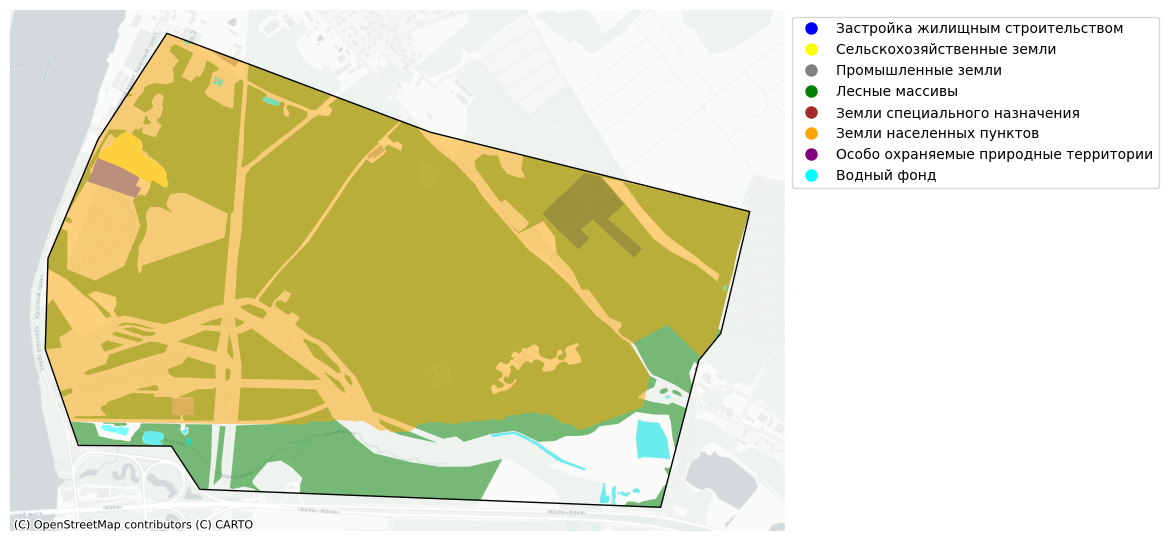

In [14]:
plot_landuse(gpd.GeoDataFrame.from_features(geojson_data["features"]), landuse_gdf)

In [2]:
from popframe.method.urbanisation_level import UrbanisationLevel
from popframe.models.region import Region
region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/model_data/region_noter.pickle')

In [4]:
urbanisation = UrbanisationLevel(region=region_model)

In [5]:
geojson_data = {
    "type": "FeatureCollection",
    "name": "project Шлиссельбург",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": [
        { "type": "Feature", "properties": { "building": None, "name": "Шлиссельбург", "addr:street": None, "addr:housenumber": None, "addr:city": None, "type": "project", "is_living": None }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 30.993913172856011, 59.924597611350642 ], [ 30.999718075936872, 59.92939124524851 ], [ 31.02331219813648, 59.925349599879553 ], [ 31.051774948726486, 59.922247536976649 ], [ 31.049527889469388, 59.916794721233835 ], [ 31.047655340088465, 59.915572415065995 ], [ 31.044659261078984, 59.908989990082127 ], [ 31.003837684574897, 59.909178077541952 ], [ 31.001216115441608, 59.911058893338229 ], [ 30.992976898165544, 59.910964855087578 ], [ 30.989793564217987, 59.915196311774075 ], [ 30.989793564217987, 59.919239198078628 ], [ 30.993913172856011, 59.924597611350642 ] ] ] } }
    ]
}
landuse_data = urbanisation.get_landuse_data(geojson_data)
landuse_data

Error fetching data for tag filter {'landuse': 'conservation'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'wood'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'railway'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'vineyard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'meadow'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'protected_area'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'animal_keeping'}: No data el

,indicator,urbanization,geometry
0,1.3.1 Процент застройки жилищным строительством,2,"MULTIPOLYGON (((31.04061 59.92242, 31.03924 59..."
1,1.3.2 Процент земель сельскохозяйственного наз...,1,"POLYGON ((30.99443 59.92418, 30.99452 59.92420..."
2,1.3.3 Процент земель промышленного назначения,0,"MULTIPOLYGON (((31.00308 59.91245, 31.00214 59..."
3,"1.3.4 Процент земель, занимаемыми лесными масс...",69,"MULTIPOLYGON (((30.99685 59.91192, 30.99674 59..."
4,1.3.6 Процент земель населенных пунктов,81,"POLYGON ((31.05176 59.92225, 31.05079 59.92050..."
5,"1.3.8 Процент земель, занимаемых водным фондом",1,"MULTIPOLYGON (((31.00294 59.91120, 31.00278 59..."


In [13]:
import pandas as pd
import geopandas as gpd

results = []
for index, row in landuse_data.iterrows():
    key = row['indicator']
    value = row['urbanization']
    results.append({
        '№ п/п': key.split(' ')[0],
        'Название хранимое': ' '.join(key.split(' ')[1:]) if ' ' in key else key,
        'ед.изм.': '%',
        'Значение': value,
        'Источник': 'modeled',
        'Период': 2024
    })

# Creating the new dataframe
new_df = pd.DataFrame(results)
new_df

,№ п/п,Название хранимое,ед.изм.,Значение,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,2,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,1,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,0,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,69,modeled,2024
4,1.3.6,Процент земель населенных пунктов,%,81,modeled,2024
5,1.3.8,"Процент земель, занимаемых водным фондом",%,1,modeled,2024


In [10]:
new_df.to_excel('Шлиссельбург.xlsx', index=False)

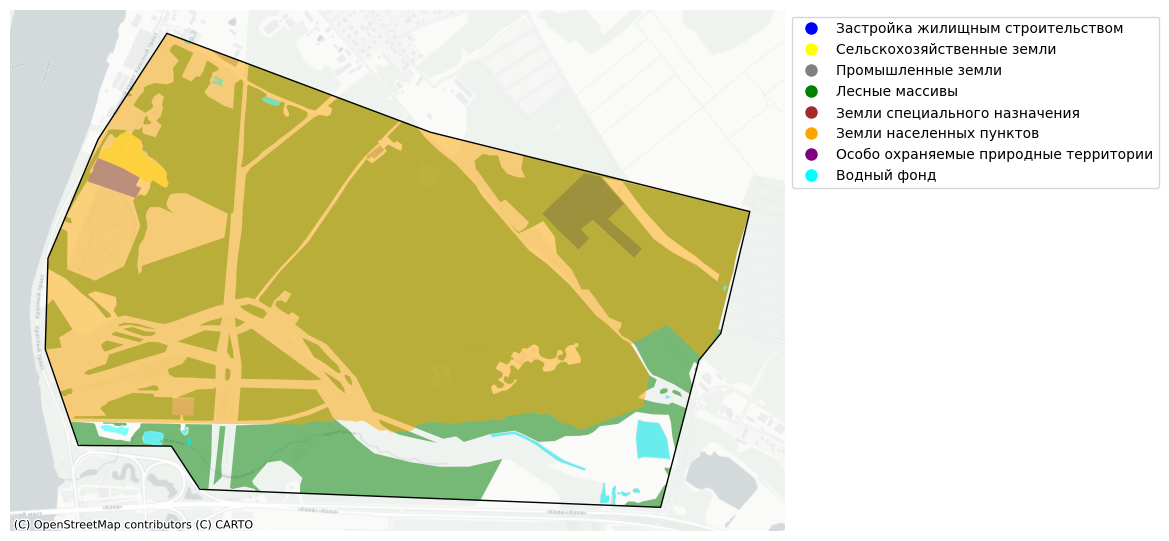

In [14]:
urbanisation.plot_landuse(gpd.GeoDataFrame.from_features(geojson_data["features"]), landuse_data)